In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('..')

In [2]:
from src.sympy_utilities import *
from src.BinaryEncodings import *
from src.MatrixToPauliString import *
from src.qiskit_utilities import *

from qiskit.algorithms.minimum_eigensolvers import VQE
from qiskit.algorithms.eigensolvers import VQD
from qiskit.algorithms.optimizers import COBYLA
from qiskit.circuit.library import RealAmplitudes
from qiskit.primitives import Estimator, Sampler
from qiskit.algorithms.state_fidelities import ComputeUncompute

from ipywidgets import IntProgress
from IPython.display import display, clear_output 

import scipy.sparse.linalg

import matplotlib.pyplot as plt
import matplotlib.lines as mlines

import os
import json
import math

In [3]:
h_b_DW = 0.5*(p*p + (m*q + g*(q*q + mu*mu))**2)
h_f_DW = -0.5*(m+2*g*q)#[bdag,b]

cutoff=16

ham=Hamiltonian(h_b_DW,h_f_DW,{m:1, g:1, mu:1}, cutoff, standard_encode)


In [4]:
hamOP = pauli_string_to_op(ham.pauliStrings)
nq=math.floor(math.log2(ham.hamMatrix.shape[0]))
if not math.log2(ham.hamMatrix.shape[0]).is_integer():
    nq+=1

In [5]:
estimator = Estimator()
sampler=Sampler()
fidelity=ComputeUncompute(sampler)

ansatz = RealAmplitudes(nq, entanglement='linear', reps=1)

In [6]:
k=7
betas=[1 for i in range(k)]

counts=[]
values=[]
steps=[]

def callback(eval_count, params, value, meta, step):
    counts.append(eval_count)
    values.append(value)
    steps.append(step)

In [13]:
print("------ cutoff = {} ------".format(cutoff))
#CLASSICAL COMPUTATION OF GROUND STATE ENERGY
ens=scipy.sparse.linalg.eigs(getMatrix(ham.pauliStrings),k=15,sigma=0.0)[0]
print("Lowest 7 energies = {}".format(ens))
print("Min energy = {:.4e}".format(np.array([x.real for x in ens]).min()))

------ cutoff = 16 ------
Lowest 7 energies = [ 0.89163849+2.39521097e-17j  0.8916501 -4.77557160e-17j
  2.73432506+1.23725960e-17j  2.73421059+2.65287925e-16j
  4.84645895+1.62749866e-16j  4.84793798-1.76329488e-16j
  7.19586103-2.88099445e-16j  7.18775479-2.43415845e-16j
  9.75001443-5.15695194e-16j  9.77982411+7.17616366e-17j
 12.8329317 -3.38535141e-16j 12.84455165-1.74245375e-16j
 17.07570042+1.25243494e-15j 17.53407955-7.97283564e-17j
 22.84419743-4.21730083e-16j]
Min energy = 8.9164e-01


[0.89370664+0.j 0.91363315+0.j 2.89141757+0.j 2.8770641 +0.j
 2.91370366+0.j]


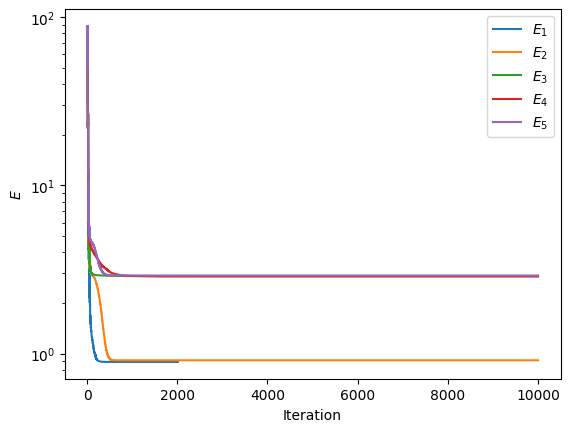

In [17]:
k=5
betas=[2,2,2,2,2]

counts=[]
values=[]
steps=[]

def callback(eval_count, params, value, meta, step):
    counts.append(eval_count)
    values.append(value)
    steps.append(step)

counts=[]
values=[]
steps=[]

vqd=VQD(estimator, fidelity, ansatz, optimizer=COBYLA(maxiter=10000, tol=1e-6), k=k, betas=betas, callback=callback)
result=vqd.compute_eigenvalues(operator=hamOP)

counts=np.asarray(counts)
steps=np.asarray(steps)
values=np.asarray(values)
for i in range(1,k+1):
    _counts=counts[np.where(steps==i)]
    _values=values[np.where(steps==i)]
    plt.plot(_counts,_values,label=r'$E_{{{}}}$'.format(i))
plt.xlabel(r'Iteration')
plt.ylabel(r'$E$')
plt.yscale('log')
plt.legend(loc='upper right')

print(result.eigenvalues)

[0.91479815+0.j 0.89371117+0.j 2.94086849+0.j 3.2495    +0.j
 4.87483572+0.j]


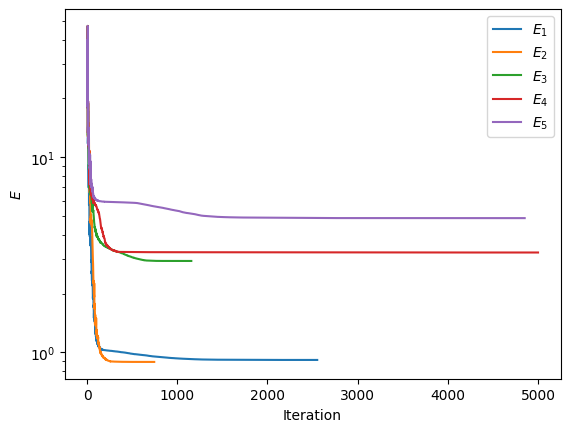

In [18]:
k=5
betas=[5 for i in range(k)]

counts=[]
values=[]
steps=[]

def callback(eval_count, params, value, meta, step):
    counts.append(eval_count)
    values.append(value)
    steps.append(step)

counts=[]
values=[]
steps=[]

vqd=VQD(estimator, fidelity, ansatz, optimizer=COBYLA(maxiter=5000, tol=1e-4), k=k, betas=betas, callback=callback)
result=vqd.compute_eigenvalues(operator=hamOP)

counts=np.asarray(counts)
steps=np.asarray(steps)
values=np.asarray(values)
for i in range(1,k+1):
    _counts=counts[np.where(steps==i)]
    _values=values[np.where(steps==i)]
    plt.plot(_counts,_values,label=r'$E_{{{}}}$'.format(i))
plt.xlabel(r'Iteration')
plt.ylabel(r'$E$')
plt.yscale('log')
plt.legend(loc='upper right')

print(result.eigenvalues)

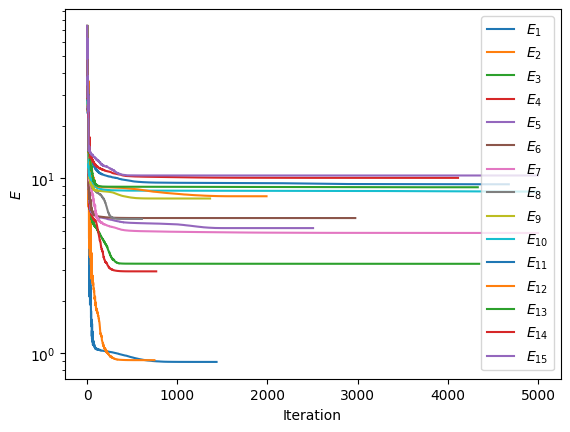

In [19]:
k=15
betas=[5 for i in range(k)]

counts=[]
values=[]
steps=[]

def callback(eval_count, params, value, meta, step):
    counts.append(eval_count)
    values.append(value)
    steps.append(step)

counts=[]
values=[]
steps=[]

vqd=VQD(estimator, fidelity, ansatz, optimizer=COBYLA(maxiter=5000, tol=1e-4), k=k, betas=betas, callback=callback)
result=vqd.compute_eigenvalues(operator=hamOP) #  < phi_k | H | phi_k > 

counts=np.asarray(counts)
steps=np.asarray(steps)
values=np.asarray(values)
for i in range(1,k+1):
    _counts=counts[np.where(steps==i)]
    _values=values[np.where(steps==i)]
    plt.plot(_counts,_values,label=r'$E_{{{}}}$'.format(i))
plt.xlabel(r'Iteration')
plt.ylabel(r'$E$')
plt.yscale('log')
plt.legend(loc='upper right')

In [20]:
print(result.eigenvalues)

[ 0.89370532+0.j  0.91479508+0.j  3.24952027+0.j  2.94151568+0.j
  5.19677803+0.j  5.93129026+0.j  4.87363334+0.j  5.8638555 +0.j
  7.67130066+0.j  8.3947556 +0.j  9.24968311+0.j  7.90100018+0.j
  8.89439465+0.j 10.06412198+0.j 10.38364088+0.j]


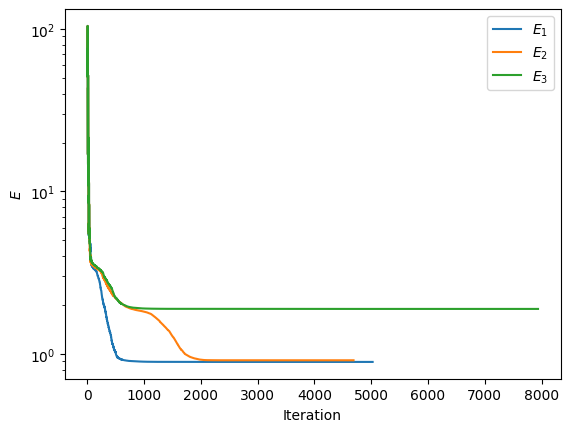

In [10]:
counts=[]
values=[]
steps=[]

vqd=VQD(estimator, fidelity, ansatz, optimizer=COBYLA(maxiter=10000, tol=1e-8), k=k, betas=betas, callback=callback)
result=vqd.compute_eigenvalues(operator=hamOP)

counts=np.asarray(counts)
steps=np.asarray(steps)
values=np.asarray(values)
for i in range(1,k+1):
    _counts=counts[np.where(steps==i)]
    _values=values[np.where(steps==i)]
    plt.plot(_counts,_values,label=r'$E_{{{}}}$'.format(i))
plt.xlabel(r'Iteration')
plt.ylabel(r'$E$')
plt.yscale('log')
plt.legend(loc='upper right')

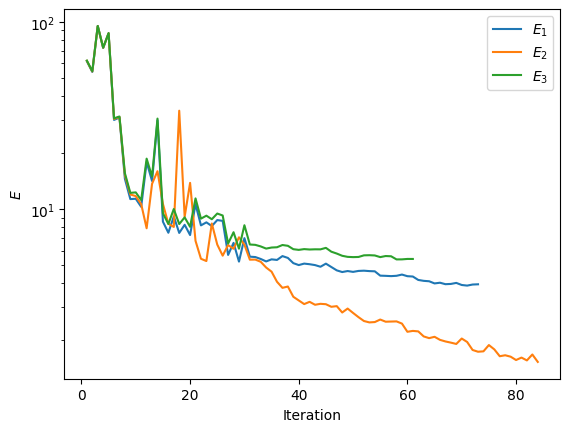

In [8]:
counts=[]
values=[]
steps=[]

vqd=VQD(estimator, fidelity, ansatz, optimizer=COBYLA(maxiter=10000, tol=1e-1), k=k, betas=betas, callback=callback)
result=vqd.compute_eigenvalues(operator=hamOP)

counts=np.asarray(counts)
steps=np.asarray(steps)
values=np.asarray(values)
for i in range(1,k+1):
    _counts=counts[np.where(steps==i)]
    _values=values[np.where(steps==i)]
    plt.plot(_counts,_values,label=r'$E_{{{}}}$'.format(i))
plt.xlabel(r'Iteration')
plt.ylabel(r'$E$')
plt.yscale('log')
plt.legend(loc='upper right')